<a href="https://colab.research.google.com/github/SummerLife/EmbeddedSystem/blob/master/MachineLearning/project/06_food_detection/food_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food detection on STM32 with Cube.AI
*This software component is licensed by ST under BSD 3-Clause license,
the "License"; You may not use this file except in compliance with the
License. You may obtain a copy of the License at:
[https://opensource.org/licenses/BSD-3-Clause](https://opensource.org/licenses/BSD-3-Clause)*

In [1]:
import os
import tensorflow as tf
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Conv2D, DepthwiseConv2D
from keras.layers import Input, Reshape, Dropout, BatchNormalization
from keras.layers import Activation, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
from shutil import copy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

print('Tensorflow version ', tf.__version__)
print('Keras version ', keras.__version__)

Using TensorFlow backend.


Tensorflow version  2.2.0
Keras version  2.3.1


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Download the Food-101 dataset
The Food-101 dataset contains 101 food classes with 1000 images per class. For each class, 250 manually reviewed test images are provided as well as 750 training images.
> Food-101 -- Mining Discriminative Components with Random Forests
> Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc
> European Conference on Computer Vision - 2014

The dataset will be downloaded and extracted by default in a *datasets* directory inside `~/.keras`. If you already have it you can copy it there or update `dataset_dir` variable.
Please note that this is a \~5Gb download so it may take a while

In [2]:
dataset_dir = os.path.expanduser('~') + '/.keras/datasets'
if os.path.isdir(dataset_dir+'/food-101'):
    print('Dataset already exists')
else:
    # Uncommenting the two lines bellow can help download the dataset
    # behind a proxy if the CERTIFICATE_VERIFY_FAILED error appears
    # Also set http_proxy and https_proxy environement variables accordingly
    #import ssl
    #ssl._create_default_https_context = ssl._create_unverified_context
    tf.keras.utils.get_file(
        'food-101.tar.gz',
        'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
        extract=True,
        archive_format='tar',
        cache_dir=None)
    print("Dataset downloaded and extracted")

4996284416/4996278331 [==============================] - 257s 0us/step
Dataset downloaded and extracted


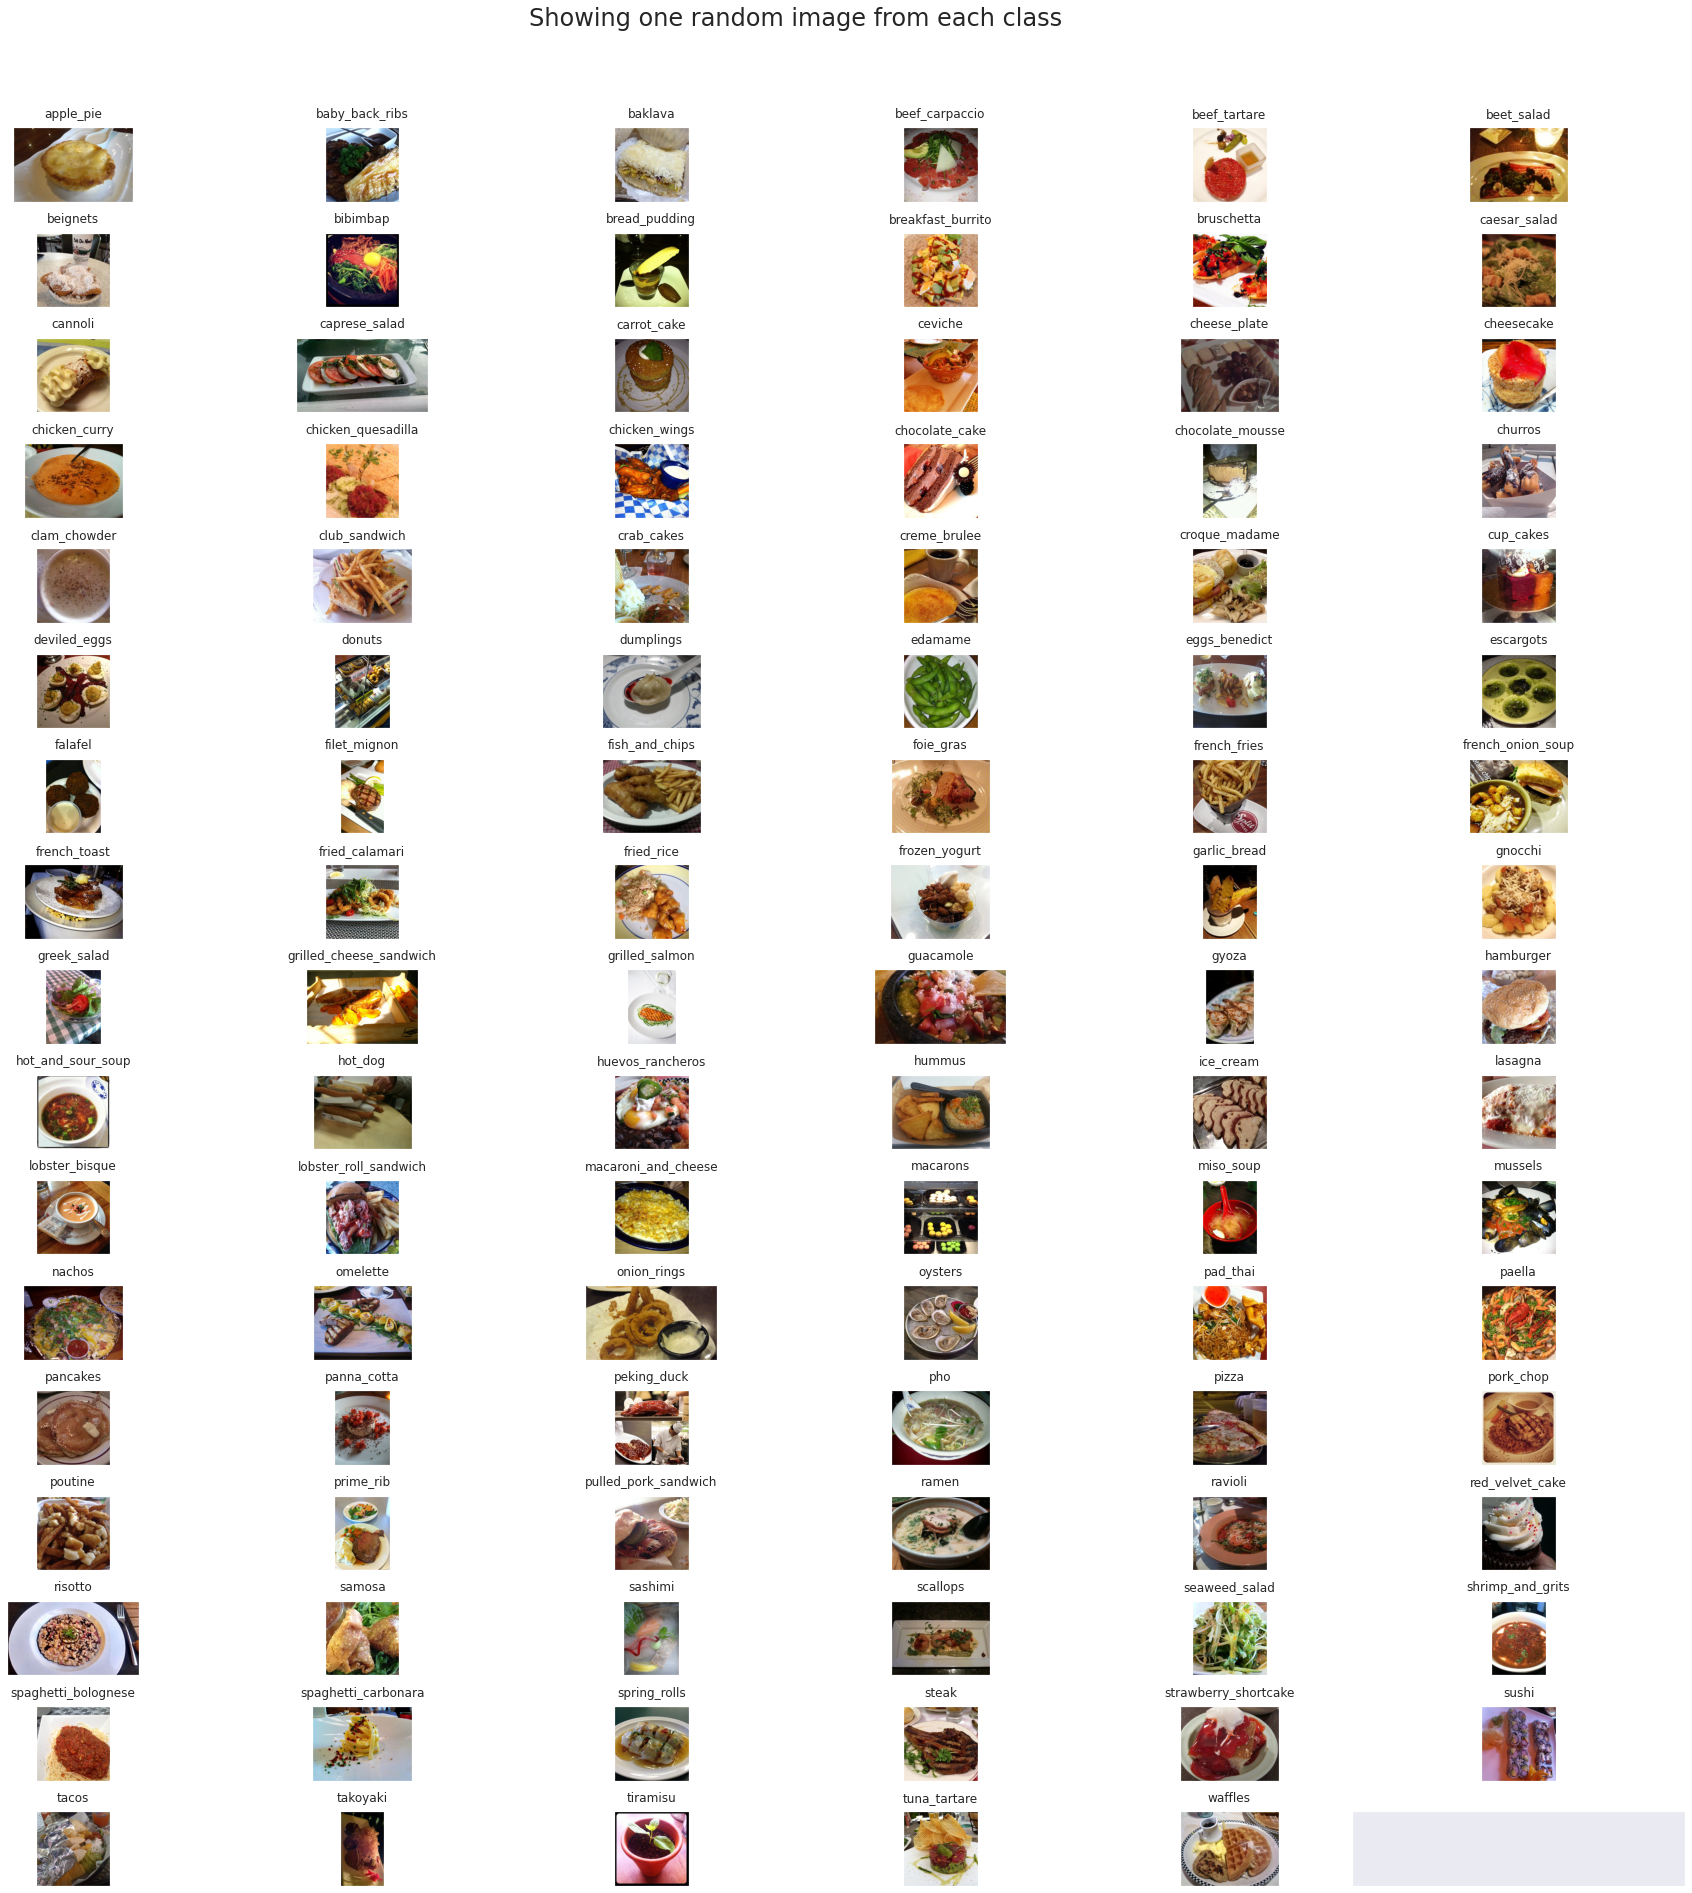

In [3]:
# Visualize the data, showing one image per class from 101 classes
rows, cols = (17, 6)
fig, ax = plt.subplots(rows, cols, figsize=(25, 25))
fig.suptitle('Showing one random image from each class', y=1.05, fontsize=24)
foods_sorted = sorted(os.listdir(dataset_dir + '/food-101/images/'))
food_id = 0
for i in range(rows):
    for j in range(cols):
        try:
            food_selected = foods_sorted[food_id]
            food_id += 1
        except:
            break
        food_selected_images = os.listdir( os.path.join(dataset_dir + '/food-101/images/', food_selected) )  
        food_selected_random = np.random.choice( food_selected_images ) 
        img = plt.imread(
            os.path.join(dataset_dir + '/food-101/images/', food_selected, food_selected_random))
        ax[i][j].imshow(img)
        ax[i][j].set_title(food_selected, pad=10)

plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()

## Create a subset of 18 classes
We limit ourselves to a smaller dataset


In [4]:
# Choose 18 foods we like
subset_class_names = [
    'apple_pie', 'beignets', 'caesar_salad', 'ceviche', 'cheesecake',
    'chicken_wings', 'chocolate_cake', 'creme_brulee', 'cup_cakes', 'donuts',
    'french_fries', 'hamburger', 'hot_dog', 'lasagna', 'pizza', 'risotto',
    'spaghetti_bolognese', 'steak'
]
nbr_classes = len(subset_class_names)
print(nbr_classes)

18


### Prepare the test and train datasets
Food-101 provides texts files to split the images between a train and a test dataset. In this section we create two directories, `train` and `test` and copy the images according to the test files provided by the authors of Food-101 dataset 

In [5]:
# For demo purpose we limit the dataset
max_imgs_per_class = np.inf

def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    if os.path.isdir(dest) and len(os.listdir(dest)) == nbr_classes:
        print('Data preparation seems to be already done. Skipping')
        #return

    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            if food[0] in subset_class_names:  # Filter out the subset
                classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
        print("Copying images into ", food)
        if not os.path.exists(os.path.join(dest, food)):
            os.makedirs(os.path.join(dest, food))
        for count, i in enumerate(classes_images[food]):
            copy(os.path.join(src, food, i), os.path.join(dest, food, i))
            if count > max_imgs_per_class: break
    print("Copying Done!")

# Prepare train dataset by copying images from food-101/images to ./train using the file train.txt
print("Creating train data...")
prepare_data(dataset_dir+'/food-101/meta/train.txt', dataset_dir+'/food-101/images', './train')

# Prepare test data by copying images from food-101/images to ./test using the file test.txt
print("Creating test data...")
prepare_data(dataset_dir+'/food-101/meta/test.txt', dataset_dir+'/food-101/images', './test')

Creating train data...
Copying images into  apple_pie
Copying images into  beignets
Copying images into  caesar_salad
Copying images into  ceviche
Copying images into  cheesecake
Copying images into  chicken_wings
Copying images into  chocolate_cake
Copying images into  creme_brulee
Copying images into  cup_cakes
Copying images into  donuts
Copying images into  french_fries
Copying images into  hamburger
Copying images into  hot_dog
Copying images into  lasagna
Copying images into  pizza
Copying images into  risotto
Copying images into  spaghetti_bolognese
Copying images into  steak
Copying Done!
Creating test data...
Copying images into  apple_pie
Copying images into  beignets
Copying images into  caesar_salad
Copying images into  ceviche
Copying images into  cheesecake
Copying images into  chicken_wings
Copying images into  chocolate_cake
Copying images into  creme_brulee
Copying images into  cup_cakes
Copying images into  donuts
Copying images into  french_fries
Copying images into 

In [6]:
# Check how many files are in the train folder
nb_train_files = sum([len(files) for i, j, files in os.walk("./train")])
print("Total number of samples in train folder {}".format(nb_train_files))

# Check how many files are in the test folder
nb_test_files = sum([len(files) for i, j, files in os.walk("./test")])
print("Total number of samples in test folder {}".format(nb_test_files))

Total number of samples in train folder 13500
Total number of samples in test folder 4500


## Data augmentation
In this section use Keras ImageDataGenerator to create generators for train, validation and test data. The train and validation data are augmented through a series of transformation (shift, zoom, rotation...)

In [7]:
batch_size = 32
validation_split = 0.25

data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.6, 1.1],
    horizontal_flip=True,
    brightness_range=[0.8, 1.3],
    channel_shift_range=2.0,
    validation_split=validation_split,
    fill_mode='nearest')

train_generator = data_gen.flow_from_directory('./train',
                                               target_size=(224, 224),
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset='training')

validation_generator = data_gen.flow_from_directory('./train',
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='validation')

test_data_gen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_data_gen.flow_from_directory('./test',
                                                   target_size=(224, 224),
                                                   batch_size=nb_test_files,
                                                   class_mode='categorical')


Found 10134 images belonging to 18 classes.
Found 3366 images belonging to 18 classes.
Found 4500 images belonging to 18 classes.


### Visualize the augmented data

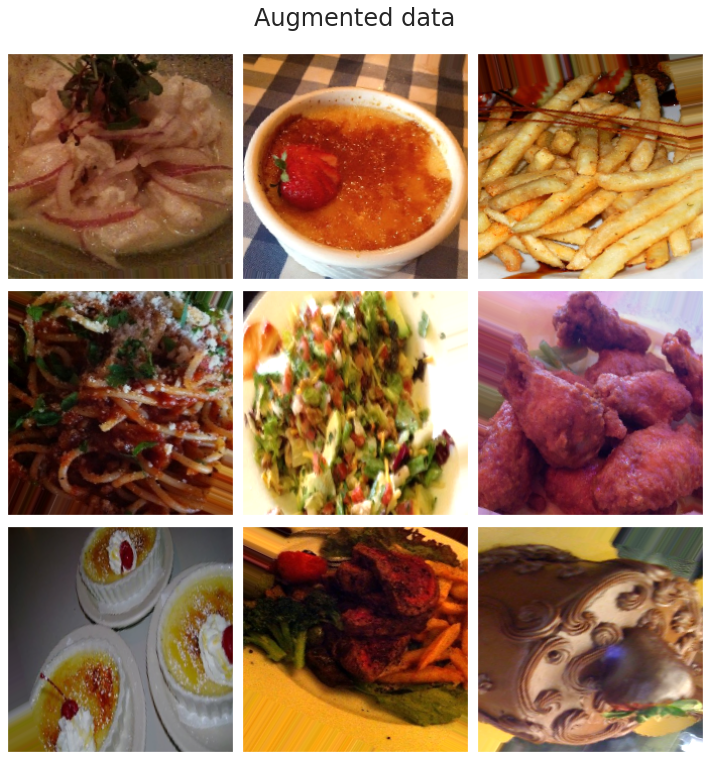

In [9]:
sample_batch = next(train_generator)
sample_batch = sample_batch[0][:9]  # Take only the first 9 images

# fig, ax = plt.subplots(3, 3, figsize=(20, 20))
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

fig.suptitle("Augmented data", y=1.05, fontsize=24)
k = 0
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(sample_batch[k])
        k += 1

plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()

## Create the model
The network used for food detection is FD-Mobilenet, for Fast Downsampling Mobilenet. It's inspired by the Mobilenet architecture which makes use of depthwise separable convolution to reduce memory footprint and inference time.

> FD-MobileNet: Improved MobileNet with A Fast Downsampling Strategy is under review as a conference paper at ICIP 2018.
[Link to the article](https://arxiv.org/abs/1802.03750)


In [11]:
def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):
    filters = int(filters * alpha)
    x = Conv2D(filters,
               kernel,
               padding='same',
               use_bias=False,
               strides=strides,
               name='conv1')(inputs)
    x = BatchNormalization(axis= -1, name='conv1_bn')(x)
    return Activation('relu', name='conv1_relu')(x)


def _depthwise_conv_block(inputs,
                          pointwise_conv_filters,
                          alpha,
                          depth_multiplier=1,
                          strides=(1, 1),
                          block_id=1):
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    x = DepthwiseConv2D((3, 3),
                        padding='same',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        use_bias=True,
                        name='conv_dw_%d' % block_id)(inputs)

    x = Conv2D(pointwise_conv_filters, (1, 1),
               padding='same',
               use_bias=False,
               strides=(1, 1),
               name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(axis=-1, name='conv_pw_%d_bn' % block_id)(x)
    return Activation('relu', name='conv_pw_%d_relu' % block_id)(x)


def create_fd_mobilenet(input_shape=None,
                        alpha=0.25,
                        depth_multiplier=1,
                        dropout=1e-3,
                        classes=18):

    if K.backend() != 'tensorflow':
        raise RuntimeError('Only Tensorflow backend is currently supported, '
                           'as other backends do not support '
                           'depthwise convolution.')

    if K.image_data_format() != 'channels_last':
        raise RuntimeError('The channel_last data format is not available '
                           'You should set `image_data_format="channels_last"` '
                           'in your Keras config located at ~/.keras/keras.json.')

    # Determine proper input shape.
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      require_flatten=True,
                                      data_format=K.image_data_format())

    img_input = Input(shape=input_shape)

    x = _conv_block(img_input, 32, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x,
                              64,
                              alpha,
                              depth_multiplier,
                              strides=(2, 2),
                              block_id=1)

    x = _depthwise_conv_block(x,
                              128,
                              alpha,
                              depth_multiplier,
                              strides=(2, 2),
                              block_id=2)

    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)

    x = _depthwise_conv_block(x,
                              256,
                              alpha,
                              depth_multiplier,
                              strides=(2, 2),
                              block_id=4)

    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)

    x = _depthwise_conv_block(x,
                              512,
                              alpha,
                              depth_multiplier,
                              strides=(2, 2),
                              block_id=6)

    #block of 4
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)

    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=11)

    shape = (1, 1, int(1024 * alpha))

    x = GlobalAveragePooling2D()(x)
    x = Reshape(shape, name='reshape_1')(x)
    x = Dropout(dropout, name='dropout')(x)
    x = Conv2D(classes, (1, 1), padding='same', name='conv_preds')(x)
    x = Activation('softmax', name='act_softmax')(x)
    x = Reshape((classes, ), name='reshape_2')(x)

    inputs = img_input
    model = Model(inputs, x, name='fd_mobilenet')

    return model

K.clear_session()
# create a model
model = create_fd_mobilenet(input_shape=None,
                            alpha=0.25,
                            depth_multiplier=1,
                            dropout=0.2,
                            classes=nbr_classes)

In [12]:
model.summary()

Model: "fd_mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 8)       216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 8)       32        
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 8)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 56, 56, 8)         80        
_________________________________________________________________
conv_pw_1 (Conv2D)           (None, 56, 56, 16)        128       
_________________________________________________________________
conv_pw_1_bn (BatchNormaliza (None, 56, 56, 16)       

## Train the model
Here for demo purposes we train the model for a few epoch on CPU

In [13]:
checkpointer = ModelCheckpoint('fd_mobilenet_food.h5',
                               monitor='val_acc',
                               save_best_only=True,
                               verbose=1)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              epochs=20,
                              validation_data=validation_generator,
                              steps_per_epoch=int( (nb_train_files*(1-validation_split)) / batch_size),
                              validation_steps=int( (nb_train_files*(validation_split)) / batch_size),
                              callbacks=[checkpointer])

Epoch 1/20
316/316 [==============================] - 204s 647ms/step - loss: 2.7140 - accuracy: 0.1433 - val_loss: 2.9154 - val_accuracy: 0.0557
Epoch 2/20
  1/316 [..............................] - ETA: 16s - loss: 2.3474 - accuracy: 0.1875

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


316/316 [==============================] - 202s 641ms/step - loss: 2.4919 - accuracy: 0.2164 - val_loss: 2.6025 - val_accuracy: 0.1494
Epoch 3/20
316/316 [==============================] - 209s 661ms/step - loss: 2.3806 - accuracy: 0.2511 - val_loss: 2.9416 - val_accuracy: 0.2223
Epoch 4/20
316/316 [==============================] - 208s 659ms/step - loss: 2.2580 - accuracy: 0.2953 - val_loss: 2.7585 - val_accuracy: 0.2169
Epoch 5/20
316/316 [==============================] - 212s 670ms/step - loss: 2.1840 - accuracy: 0.3230 - val_loss: 2.4283 - val_accuracy: 0.2891
Epoch 6/20
316/316 [==============================] - 216s 684ms/step - loss: 2.1068 - accuracy: 0.3450 - val_loss: 2.6913 - val_accuracy: 0.2166
Epoch 7/20
316/316 [==============================] - 205s 649ms/step - loss: 2.0360 - accuracy: 0.3655 - val_loss: 2.3669 - val_accuracy: 0.2567
Epoch 8/20
316/316 [==============================] - 200s 633ms/step - loss: 1.9594 - accuracy: 0.3923 - val_loss: 2.1175 - val_accura

## Plot accuracy and loss

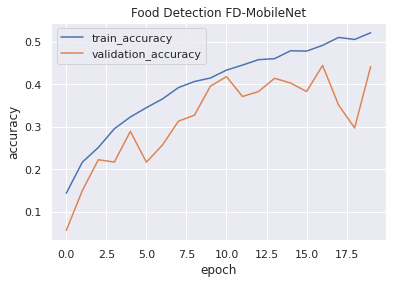

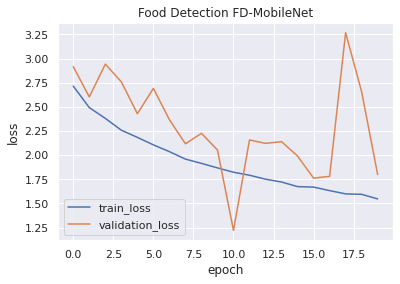

In [17]:
def plot_history(history, field, title):
    plt.title(title)
    plt.plot(history.history[field])
    plt.plot(history.history['val_{}'.format(field)])
    plt.ylabel(field)
    plt.xlabel('epoch')
    plt.legend(['train_{}'.format(field), 'validation_{}'.format(field)],
               loc='best')
    plt.show()

plot_history(history, 'accuracy', 'Food Detection FD-MobileNet')
plot_history(history, 'loss', 'Food Detection FD-MobileNet')

## Evaluate the network

                     precision    recall  f1-score   support

          apple_pie       0.23      0.11      0.15       250
           beignets       0.43      0.70      0.53       250
       caesar_salad       0.60      0.59      0.60       250
            ceviche       0.36      0.14      0.21       250
         cheesecake       0.53      0.49      0.51       250
      chicken_wings       0.82      0.21      0.34       250
     chocolate_cake       0.49      0.55      0.52       250
       creme_brulee       0.30      0.82      0.44       250
          cup_cakes       0.47      0.41      0.44       250
             donuts       0.27      0.24      0.26       250
       french_fries       0.86      0.35      0.50       250
          hamburger       0.66      0.38      0.48       250
            hot_dog       0.65      0.24      0.35       250
            lasagna       0.44      0.44      0.44       250
              pizza       0.42      0.53      0.47       250
            risotto    

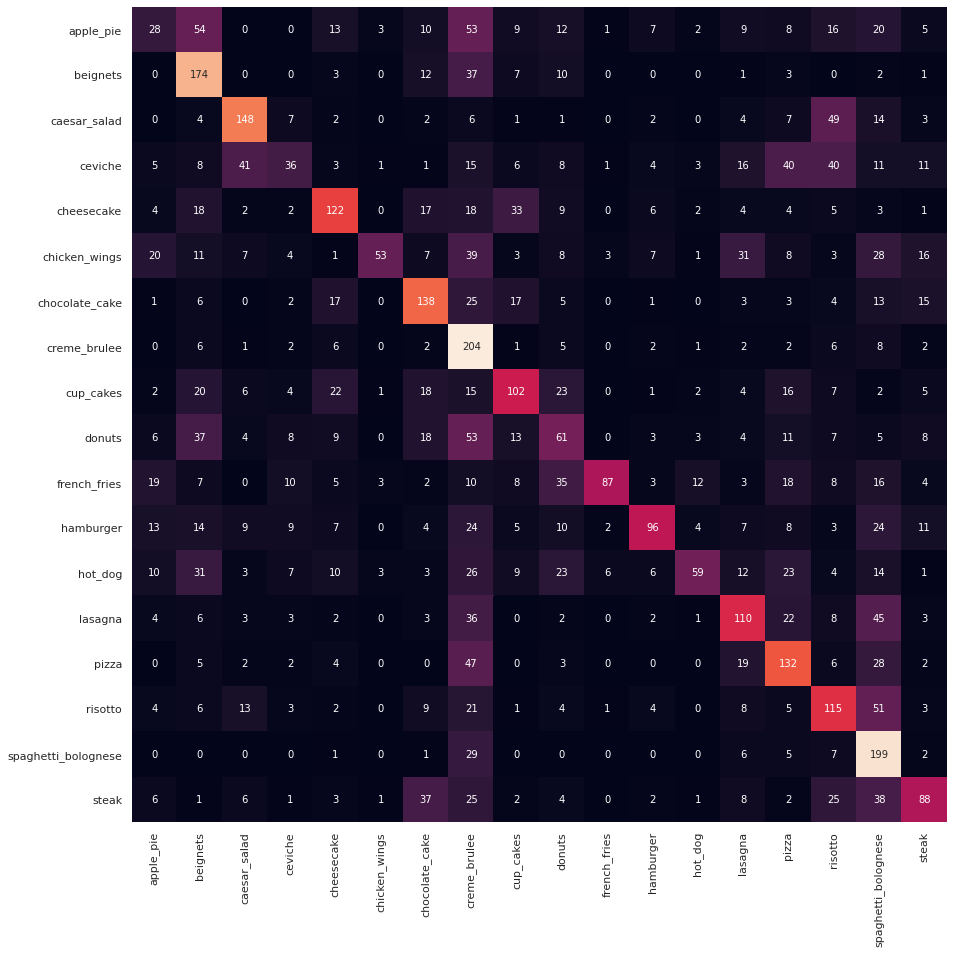

In [16]:
def evaluate_network(model, test_data):
    X_test, y_test = test_data
    y_pred = model.predict(X_test)
    y_test = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    print(classification_report(y_test, y_pred, target_names=subset_class_names))

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    ax = sns.heatmap(cm,
                square=True,
                annot=True,
                yticklabels=subset_class_names,
                xticklabels=subset_class_names,
                cbar=False,
                fmt='d')

test_data = next(test_generator)
evaluate_network(model, test_data)

In [18]:
model.save("food_detection.h5")